In [1]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 22.3 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.5.1
    Uninstalling imageio-ffmpeg-0.5.1:
      Successfully uninstalled imageio-ffmpeg-0.5.1


**1-a. Import Libraries**

In [2]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid

from PIL import Image

import numpy as np

import copy
import pickle
import os

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [3]:
%matplotlib inline

**1-b. clone the `stylegan2-ada`'s git repository**

In [4]:
# add align_images.py
if not os.path.isdir("stylegan2-ada-pytorch"):
 !git clone https://github.com/rkuo2000/stylegan2-ada-pytorch
%cd stylegan2-ada-pytorch

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 151, done.
remote: Total 151 (delta 0), reused 0 (delta 0), pack-reused 151
Receiving objects: 100% (151/151), 1.13 MiB | 19.26 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/stylegan2-ada-pytorch


In [5]:
if not os.path.isdir("pretrained"):
  !mkdir pretrained
  %cd pretrained
  !wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
  %cd ../

/content/stylegan2-ada-pytorch/pretrained
--2024-06-27 11:32:34--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 18.238.243.68, 18.238.243.45, 18.238.243.74, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|18.238.243.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘ffhq.pkl’

ffhq.pkl            100%[===================>] 363.94M   230MB/s    in 1.6s    

2024-06-27 11:32:36 (230 MB/s) - ‘ffhq.pkl’ saved [381624121/381624121]

/content/stylegan2-ada-pytorch


**1-c. load pre-trained model that trained on `ffhq` dataset**

In [6]:
with open('pretrained/ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()

### Step 2. generate sample fake-dog images

**2-a. A quick look at the model**

The image generator `G` can be used like this :

In [7]:
!gdown --id 1zIEGC4uPVsjkZpL6be0UR2b4mQRq7rn9

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zIEGC4uPVsjkZpL6be0UR2b4mQRq7rn9
To: /content/stylegan2-ada-pytorch/projected_w.npy
100% 37.0k/37.0k [00:00<00:00, 64.1MB/s]


In [8]:
# Retrieving Generator
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

In [9]:
z = torch.randn([1, G.z_dim]).cuda()
w = G.mapping(z, None)
#w=torch.from_numpy(np.load('projected_w.npy')).cuda().unsqueeze(0) #Uncomment when using your own images"
img = G.synthesis(w, noise_mode='const')


Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


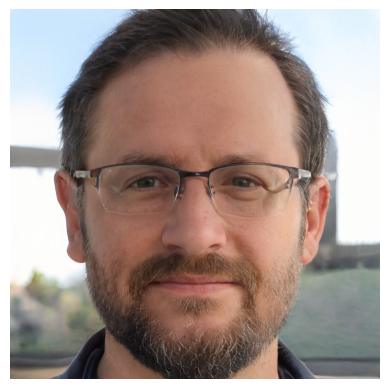

In [10]:
plt.imshow( (img[0]* 127.5 + 128).permute(1,2,0).clamp(0, 255).detach().cpu().to(torch.uint8))
plt.axis('off')
plt.show();

In [11]:
!gdown --id 1waSWjrS4StitDVtU2exsK9CwukOBkcX5
!unzip SVM_vectors.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1waSWjrS4StitDVtU2exsK9CwukOBkcX5
To: /content/stylegan2-ada-pytorch/SVM_vectors.zip
100% 33.9k/33.9k [00:00<00:00, 53.7MB/s]
Archive:  SVM_vectors.zip
   creating: SVM_vectors/
  inflating: SVM_vectors/class_direction_W_on_3k_att15.pt  
  inflating: SVM_vectors/class_direction_W_on_3k_att20.pt  
  inflating: SVM_vectors/class_direction_W_on_3k_att22.pt  
  inflating: SVM_vectors/class_direction_W_on_3k_att31.pt  
  inflating: SVM_vectors/class_direction_W_on_3k_att39.pt  
  inflating: SVM_vectors/class_direction_Z_on_3k_att15.pt  
  inflating: SVM_vectors/class_direction_Z_on_3k_att20.pt  
  inflating: SVM_vectors/class_direction_Z_on_3k_att22.pt  
  inflating: SVM_vectors/class_direction_Z_on_3k_att31.pt  
  inflati

In [12]:
ATTR_numbers=[31, 39, 15, 20,22]
ATTRS = ['Smiling','Young','Eyeglasses','Male','Mustache']
directions = {}
intercepts = {}
for i, attr_name in enumerate(ATTRS):


  directions[attr_name] = torch.load( f'SVM_vectors/class_direction_W_on_3k_att{ATTR_numbers[i]}.pt').cuda()

  intercepts[attr_name] = torch.load( f'SVM_vectors/W_intercept_on_3k_att{ATTR_numbers[i]}.pt').cuda()


(-0.5, 1023.5, 1023.5, -0.5)

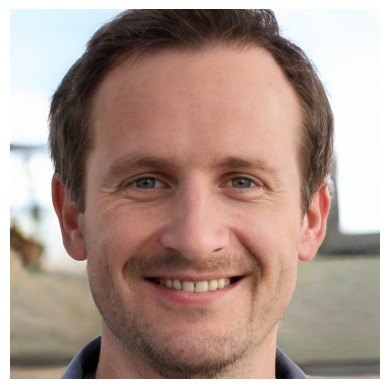

In [23]:
#@title { display-mode: "form", run: "auto" }
Young =-0.9 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Eyeglasses = -0.9 #@param {type:"slider", min:-2.9, max:3.0, step:0.1}
Male = 0#@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Smiling = 0.3 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Mustache = -1.8 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
direction=1
tensor_transformed =  w[0].clone()
for i, attr_name in enumerate(ATTRS):

        norm = torch.norm(directions[attr_name])
        #if eval(attr_name)>0:
          #distance = -(torch.dot(directions[attr_name], tensor_transformed[0]) +intercepts[attr_name])/norm**2 # in order to move the tensor onto the hyperplane.
        tensor_transformed +=   eval(attr_name)*directions[attr_name]*direction
tensor_transformed = tensor_transformed.to(device)

img = G.synthesis(tensor_transformed[None, :, :]).cpu().detach().numpy()[0].transpose((1,2,0)) # synthesis needs shape (batch, 18, 512)
img = (img+1)/2
plt.imshow(np.clip((255*img).astype(int), 0, 255))
plt.axis('off')